# Entrenamiento

In [1]:
import numpy as np 
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt


In [2]:
models_results = {}

### Cargado de datos

In [3]:
for i in range(1, 8):
    file_name_train = f'../data/dataFrame_final/final_train/df_final_train_{i}.csv'
    globals()[f'df_train_{i}'] = pd.read_csv(file_name_train, encoding='ISO-8859-1')
    print(f'Archivo {file_name_train} cargado en df_train_{i}')

    file_name_test = f'../data/dataFrame_final/final_test/df_final_test_{i}.csv'
    globals()[f'df_test_{i}'] = pd.read_csv(file_name_test, encoding='ISO-8859-1')
    print(f'Archivo {file_name_test} cargado en df_test_{i}')

Archivo ../data/dataFrame_final/final_train/df_final_train_1.csv cargado en df_train_1
Archivo ../data/dataFrame_final/final_test/df_final_test_1.csv cargado en df_test_1
Archivo ../data/dataFrame_final/final_train/df_final_train_2.csv cargado en df_train_2
Archivo ../data/dataFrame_final/final_test/df_final_test_2.csv cargado en df_test_2
Archivo ../data/dataFrame_final/final_train/df_final_train_3.csv cargado en df_train_3
Archivo ../data/dataFrame_final/final_test/df_final_test_3.csv cargado en df_test_3
Archivo ../data/dataFrame_final/final_train/df_final_train_4.csv cargado en df_train_4
Archivo ../data/dataFrame_final/final_test/df_final_test_4.csv cargado en df_test_4
Archivo ../data/dataFrame_final/final_train/df_final_train_5.csv cargado en df_train_5
Archivo ../data/dataFrame_final/final_test/df_final_test_5.csv cargado en df_test_5
Archivo ../data/dataFrame_final/final_train/df_final_train_6.csv cargado en df_train_6
Archivo ../data/dataFrame_final/final_test/df_final_test_6

### Normalización


Es necesaria normalización para Redes neuronales y recomendada para Regresión Logística, SVM, Regresión Lineal y Polinomial

### Definición de funciones

In [4]:
from sklearn import metrics
from sklearn.linear_model import SGDRegressor
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA


In [ ]:
!pip3.12 install dask dask-ml joblib

In [5]:
# Recibe un modelo entrenado y realiza una predicción sobre los conjuntos de entrenamiento y test para evaluarlo
def evaluate_model(X, y, model, model_name):
        
    raw_predictions = model.predict(X)
    if model_name == 'LinearRegression' or model_name == 'PolinomialRegression' or model_name == 'new_LinearRegression':
        predictions = [round(x) for x in raw_predictions]
        average = 'macro'
    else:
        predictions = raw_predictions 
        average = 'binary'
        
    accuracy = metrics.accuracy_score(y, predictions)
    precision, recall, fscore, _ = metrics.precision_recall_fscore_support(
        y, predictions, average=average, zero_division=0
    )
    train_auc = metrics.roc_auc_score(y, predictions)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': fscore,
        'auc': train_auc,
        'num_samples': len(y)  
    }
    


In [6]:
def prediction(model, model_name, pca=False):
    results_list = {
        'train': [],
        'test': []
    }

    for i in range(1, 8):
        if pca : 
            data_train = globals()[f'df_train_{i}_pca']
            data_test = globals()[f'df_test_{i}_pca']
        else:
            data_train = globals()[f'df_train_{i}']
            data_test = globals()[f'df_test_{i}']

        X_train = data_train.drop(columns=['label']).values
        y_train = data_train['label'].values

        
        X_test = data_test.drop(columns=['label']).values
        y_test = data_test['label'].values

        train_partition_results = evaluate_model(X_train, y_train, model, model_name)
        results_list['train'].append(train_partition_results)

        test_partition_results = evaluate_model(X_test, y_test, model, model_name)
        results_list['test'].append(test_partition_results)

    # Guardar resultados de cada partición en models_results
    models_results[f'{model_name}'] = results_list


In [7]:
def plot_results(model_name):
    train_f1_scores = [result['f1_score'] for result in models_results[f'{model_name}']['train']]
    test_f1_scores = [result['f1_score'] for result in models_results[f'{model_name}']['test']]

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 8), train_f1_scores, label='Train F1 Score', marker='o', color='blue')
    plt.plot(range(1, 8), test_f1_scores, label='Test F1 Score', marker='o', color='red')
    plt.title(f'Comparación de F1 en {model_name}')
    plt.xlabel('Número de partición')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()


In [8]:
def plot_model_comparison(models_results, metric='accuracy'):
    models = list(models_results.keys())
    train_scores = []
    test_scores = []
    
    for model in models:
        train_metric = np.mean([entry[metric] for entry in models_results[model]['train']])
        test_metric = np.mean([entry[metric] for entry in models_results[model]['test']])
        
        train_scores.append(train_metric)
        test_scores.append(test_metric)
    
    x = np.arange(len(models))
    width = 0.25  

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x - width/2, train_scores, width, label='Train')
    ax.bar(x + width/2, test_scores, width, label='Test')

    ax.set_xlabel('Models')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} by model')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()



### Regresión Lineal DONE

##### Entrenamiento

Como LinealRegression no permite hacer partial fit, usamos SGDRegressor con loss = squared error y así realiza lo mismo que el original, minimizar el error cuadrático

In [44]:
model = SGDRegressor(loss='squared_error', random_state=42)

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values
    
    model.partial_fit(X_train, y_train)


In [45]:
dir = "../data/models"
model_path = os.path.join(dir, "LinearRegression.joblib")
joblib.dump(model, model_path)

['../data/models\\LinearRegression.joblib']

##### Predicción

In [9]:
# Cargar modelo de LinearRegression
model = joblib.load("../data/models/LinearRegression.joblib")

c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SGDRegressor from version 1.5.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
prediction(model, 'LinearRegression')

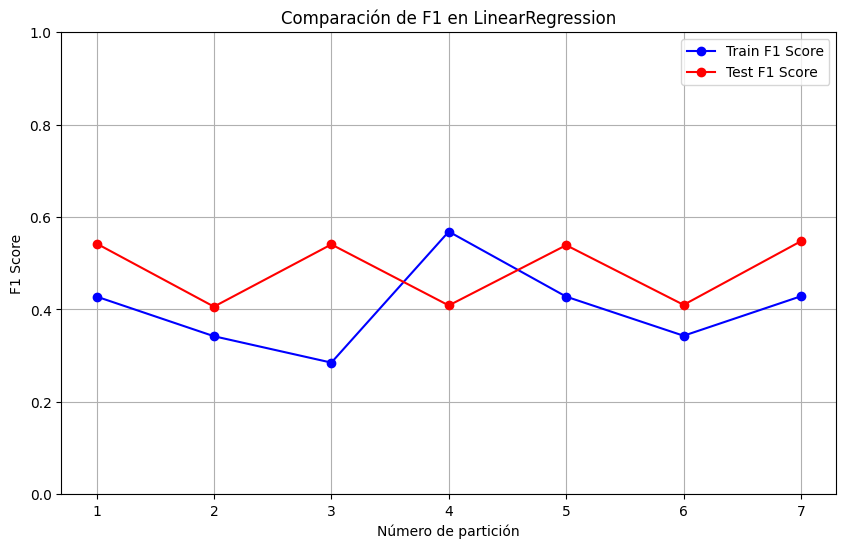

In [11]:
plot_results('LinearRegression')

### Regresión Polinomial DONE

Tenemos un problema ya que la matriz generada por aumentar el grado de los datos es demasiado grande aunque sea simplemente de grado 2.

Debido al tamaño del dataframe no podemos utilizar SVC así que intentaré aplicar un PCA y ver con cuántas columnas me quedo

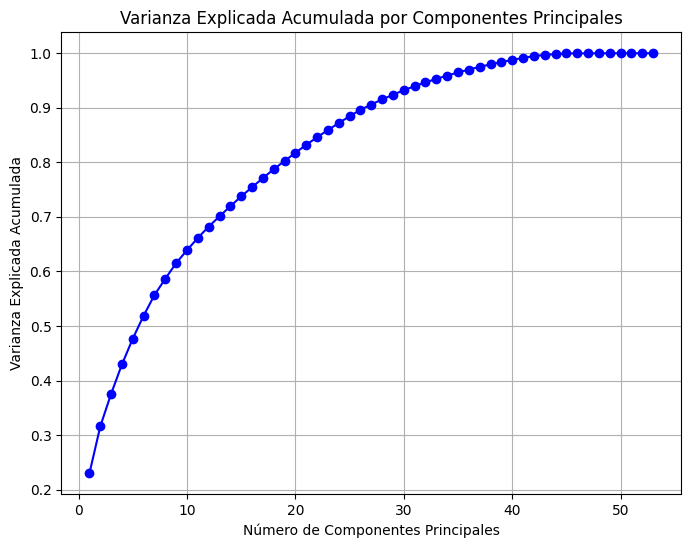

El número óptimo de componentes es 33


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler

pca = IncrementalPCA(n_components=53) 
scaler = StandardScaler()

explained_variance_ratio = []  

for i in range(1, 8):
    df_part = globals()[f'df_train_{i}']
    X_part = df_part.drop(columns=['label'])  
    X_train_scaled = scaler.fit_transform(X_part) if i == 1 else scaler.transform(X_part)  # Escalar
    
    pca.partial_fit(X_train_scaled)
    
    explained_variance_ratio.append(pca.explained_variance_ratio_)

total_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(total_explained_variance) + 1), total_explained_variance, marker='o', color='b')
plt.title('Varianza Explicada Acumulada por Componentes Principales')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.grid(True)
plt.show()

# Puedes elegir cuántos componentes usar basado en la varianza explicada acumulada
# Por ejemplo, si deseas que se explique al menos el 95% de la varianza
n_components_opt = np.argmax(total_explained_variance >= 0.95) + 1  # Primer componente que llega al 95%
print(f"El número óptimo de componentes es {n_components_opt}")


In [35]:
# Generar un dataframes pca
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
n_components = 33  

pca = PCA(n_components=n_components)

for i in range(1,8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values    

    data_test = globals()[f'df_test_{i}']
    X_test = data_test.drop(columns=['label']).values
    y_test = data_test['label'].values

    
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)


    # Lo guardo en un DataFrame para usarlo luego
    data_train_pca = pd.DataFrame(data=X_train_pca, columns=[f'PC{i}' for i in range(1, n_components+1)])
    data_train_pca['label'] = y_train
    globals()[f'df_train_{i}_pca'] = data_train_pca

    data_test_pca = pd.DataFrame(data=X_test_pca, columns=[f'PC{i}' for i in range(1, n_components+1)])
    data_test_pca['label'] = y_test
    globals()[f'df_test_{i}_pca'] = data_test_pca

In [36]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

degree = 2   # ESTE DATO TENEMOS QUE AJUSTARLO (define el grado del polinomio)

model = SGDRegressor(max_iter=1, tol=None, warm_start=True)

poly = PolynomialFeatures(degree)
scaler = StandardScaler()

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}_pca']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values

    X_train_poly = poly.fit_transform(X_train)  
    if i == 1:
        X_train_scaled = scaler.fit_transform(X_train_poly)  
    else:
        X_train_scaled = scaler.transform(X_train_poly) 
        
    model.partial_fit(X_train_scaled, y_train)


In [37]:
dir = "../data/models"
model_path = os.path.join(dir, "PolinomialRegression.joblib")
joblib.dump(model, model_path)

['../data/models\\PolinomialRegression.joblib']

##### Predicción

In [38]:
# Cargar modelo de LogisticRegression
model = joblib.load("../data/models/PolinomialRegression.joblib")

In [26]:
# from sklearn.preprocessing import PolynomialFeatures, StandardScaler


# poly = PolynomialFeatures(degree)
# scaler = StandardScaler()


# for i in range(1, 8):
#     data_train = globals()[f'df_train_{i}_pca']
#     X_train = data_train.drop(columns=['label']).values
#     y_train = data_train['label'].values

#     data_test = globals()[f'df_test_{i}_pca']
#     X_test = data_test.drop(columns=['label']).values
#     y_test = data_test['label'].values

#     X_test_poly = poly.fit_transform(X_test)
#     X_train_poly = poly.fit_transform(X_train)  
#     if i == 1:
#         X_train_scaled = scaler.fit_transform(X_train_poly)  
#         X_test_scaled = scaler.fit_transform(X_test_poly)
#     else:
#         X_train_scaled = scaler.transform(X_train_poly) 
#         X_test_scaled = scaler.transform(X_test_poly)

#     data_train_poly = pd.DataFrame(data=X_train_scaled)
#     data_train_poly['label'] = y_train
#     globals()[f'df_train_{i}_pca_poly'] = data_train_poly

#     data_test_poly = pd.DataFrame(data=X_test_scaled)
#     data_test_poly['label'] = y_test
#     globals()[f'df_test_{i}_pca_poly'] = data_test_poly


In [40]:
prediction(model, 'PolinomialRegression')

ValueError: X has 54 features, but SGDRegressor is expecting 595 features as input.

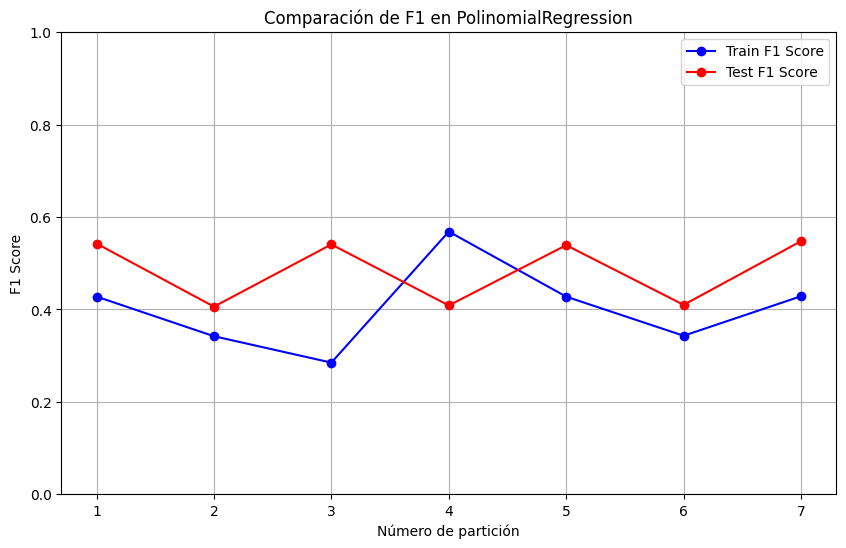

In [ ]:
plot_results('PolinomialRegression')

### Regresión Logística: DONE

##### Entrenamiento

Como LinearRegression no permite un entrenamiento por partes, usamos SGDClasifier en su lugar con "loss='log'" para realizar una clasificación utilizando el algoritmo de gradiente descendente estocástico.

In [24]:
model = SGDClassifier(loss='log_loss', random_state=42)

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values

    model.partial_fit(X_train, y_train, classes=np.unique(y_train))


In [25]:
dir = "../data/models"
model_path = os.path.join(dir, "LogisticRegression.joblib")
joblib.dump(model, model_path)


['../data/models\\LogisticRegression.joblib']

##### Predicción

In [41]:
# Cargar modelo de LogisticRegression
model = joblib.load("../data/models/LogisticRegression.joblib")

c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SGDClassifier from version 1.5.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [42]:
prediction(model, 'LogisticRegression')

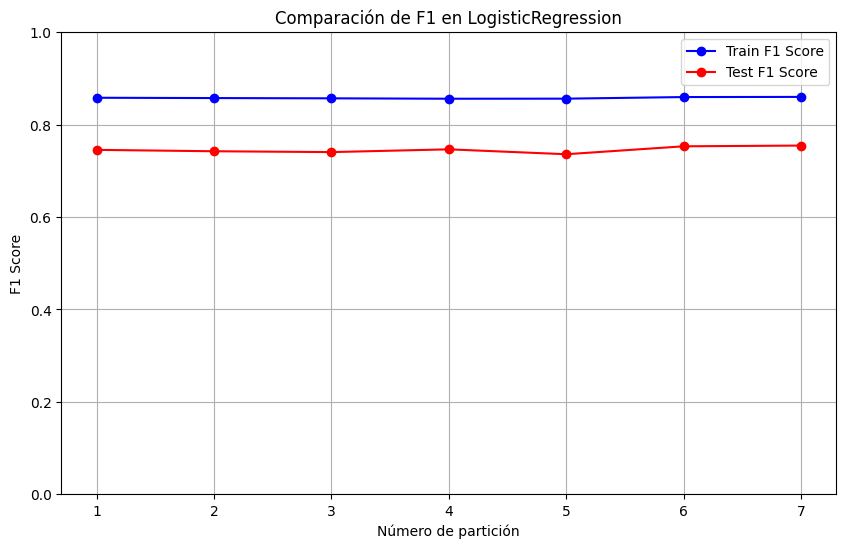

In [43]:
plot_results('LogisticRegression')

### Árboles de decisión: NO SÉ SI ESTÁ BIEN HECHO

Se recomienda hacer un PCA cuando tenemos alta dimensionalidad

In [104]:
for i in range(1,8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values    

    data_test = globals()[f'df_test_{i}']
    X_test = data_test.drop(columns=['label']).values
    y_test = data_test['label'].values

    # Aplicar PCA para reducir la dimensionalidad
    n_components = 2  # DATO AJUSTABLE
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Lo guardo en un DataFrame para usarlo luego
    data_train_pca = pd.DataFrame(data=X_train_pca, columns=[f'PC{i}' for i in range(1, n_components+1)])
    data_train_pca['label'] = y_train
    globals()[f'df_train_{i}_pca'] = data_train_pca

    data_test_pca = pd.DataFrame(data=X_test_pca, columns=[f'PC{i}' for i in range(1, n_components+1)])
    data_test_pca['label'] = y_test
    globals()[f'df_test_{i}_pca'] = data_test_pca

##### Entrenamiento

Los árboles de decisión no soportan partial_fit() así que optamos por generar un árbol para cada partición y luego aplicar un ensemble

<i>"Para la clasificación con pocas clases, min_samples_leaf=1 suele ser la mejor opción.
"</i>
<br> <br><i>"Podemos empezar con min_muestras_hoja=5 como valor inicial. Si el tamaño de la muestra varía mucho, se puede utilizar un número flotante como
porcentaje en estos dos parámetros."</i>

VotingClassifier -> hace una "votación por mayoría" de los árboles por separado para obtener la predicción final. "soft" indica que utiliza el promedio de probabilidades en lugar de la mayoría de votos

In [121]:
models = []

for i in range(1, 8):
    data_frame = globals()[f'df_train_{i}']
    X_batch = data_frame.drop(columns=['label']).values
    y_batch = data_frame['label'].values

    # Entrenar un modelo individual para cada partición !!!!!!
    model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1)
    model.fit(X_batch, y_batch)
    models.append((f'model_{i}', model))

# Hacer el ensemble
ensemble_model = VotingClassifier(estimators=models, voting='soft')


No sé para qué hago esto si me obliga luego a entrenarlo con todos los datos duh

In [122]:

X_train_full = np.vstack([globals()[f'df_train_{i}'].drop(columns=['label']).values for i in range(1, 8)])
y_train_full = np.hstack([globals()[f'df_train_{i}']['label'].values for i in range(1, 8)])

# Ajustar el ensemble con los datos completos
ensemble_model.fit(X_train_full, y_train_full)

VotingClassifier(estimators=[('model_1', DecisionTreeClassifier(max_depth=3)),
                             ('model_2', DecisionTreeClassifier(max_depth=3)),
                             ('model_3', DecisionTreeClassifier(max_depth=3)),
                             ('model_4', DecisionTreeClassifier(max_depth=3)),
                             ('model_5', DecisionTreeClassifier(max_depth=3)),
                             ('model_6', DecisionTreeClassifier(max_depth=3)),
                             ('model_7', DecisionTreeClassifier(max_depth=3))],
                 voting='soft')

In [124]:
dir = "../data/models"
model_path = os.path.join(dir, "DecisionTree.joblib")
joblib.dump(ensemble_model, model_path)

['../data/models\\DecisionTree.joblib']

##### Predicción

In [125]:
# Cargar modelo de LogisticRegression
model = joblib.load("../data/models/DecisionTree.joblib")

In [127]:
prediction(model, 'DecisionTree')

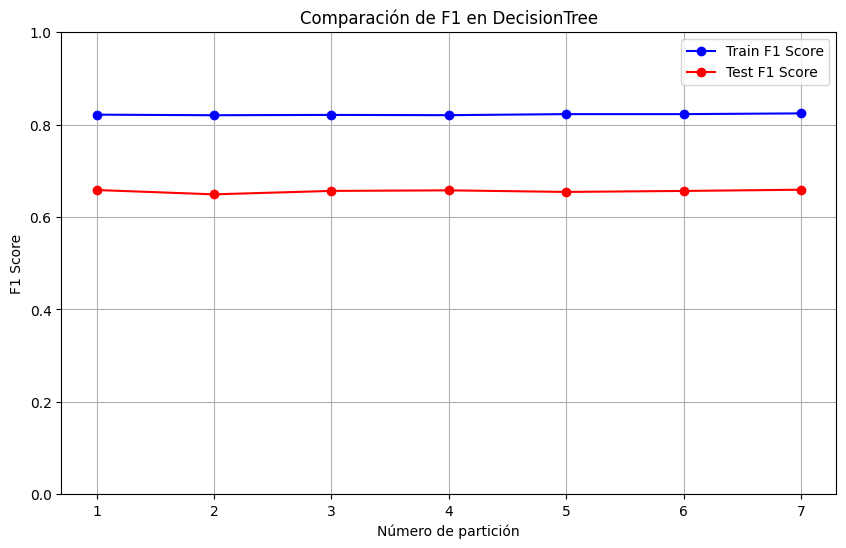

In [120]:
plot_results('DecisionTree')

### Basado en instancias : KNN -> DONE? (solo con una partición pequeña)

##### Entrenamiento

He intentado con annoy (según la documentación, permite aproximar KNN con un enfoque eficiente en memoria) pero el kernel muere intentando entrenarlo

Como no sirve nada, voy a coger una muestra pequeña representativa y voy a entrenar el modelo con ella

In [19]:
import pandas as pd

# Definir el tamaño de la muestra (1% en este ejemplo)
sample_fraction = 0.01  # Ajusta esto según tus necesidades

# DataFrames particionados de tus datos, aquí simulados como lista
partitions = [globals()[f'df_train_{i}'] for i in range(1, 8)]

# Crear lista para almacenar las muestras
sampled_data = []

# Iterar sobre cada partición y tomar una muestra estratificada
for df in partitions:
    sampled_df = df.groupby('label', as_index=False).apply(
        lambda x: x.sample(frac=sample_fraction, random_state=42)
    ).reset_index(drop=True)  # Eliminar índice adicional
    sampled_data.append(sampled_df)

# Concatenar todas las muestras para tener un único DataFrame de muestra
final_sample = pd.concat(sampled_data, ignore_index=True)

# Confirmación de la muestra final y de que 'label' está presente
print("Tamaño de la muestra final:", final_sample.shape)


C:\Users\eleni\AppData\Local\Temp\ipykernel_3320\2424558243.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label', as_index=False).apply(
C:\Users\eleni\AppData\Local\Temp\ipykernel_3320\2424558243.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label', as_index=False).apply(
C:\Users\eleni\AppData\Local\Temp\ipykernel_3320\2424558243.py:14: Depre

Tamaño de la muestra final: (39182, 55)


C:\Users\eleni\AppData\Local\Temp\ipykernel_3320\2424558243.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label', as_index=False).apply(
C:\Users\eleni\AppData\Local\Temp\ipykernel_3320\2424558243.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label', as_index=False).apply(


In [18]:
print(final_sample.columns)


Index(['ID', 'Payment_6804', 'Infraction_CGP', 'Base_7744', 'Base_80863',
       'Risk_1930', 'Infraction_SNZ', 'Base_02683', 'Infraction_QJJF',
       'Base_76065', 'Risk_0322', 'Infraction_GGO', 'Base_39598', 'Base_6187',
       'Base_85131', 'Risk_9995', 'Infraction_AYWV', 'Base_36384',
       'Base_24406', 'Infraction_BSU', 'Infraction_ZYW', 'Base_1039',
       'Base_0580', 'Expenditure_RGD', 'Base_69608', 'Base_6852', 'Base_22178',
       'Infraction_ZTYG', 'Expenditure_UWVG', 'Base_3041', 'Payment_3207',
       'Infraction_QKZN', 'Infraction_CZE', 'Base_66195', 'Risk_4553',
       'Base_67585', 'Infraction_HFSI', 'Infraction_ETH', 'Base_2810',
       'Risk_8902', 'Infraction_BGGU', 'Infraction_NMCB', 'Infraction_XEPQ',
       'Infraction_ZMKI', 'Infraction_RKTA', 'Infraction_SIA',
       'Infraction_QEY', 'Infraction_VHHP', 'Infraction_LIES',
       'Infraction_QWWW', 'Infraction_YQXM', 'Infraction_QGR',
       'Infraction_LSX', 'Expenditure_AHF_year', 'label'],
      dtype='obje

In [20]:
# Entrenar un modelo de KNN con final_sample
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
X = final_sample.drop(columns=['label']).values
y = final_sample['label'].values
model.fit(X, y)

KNeighborsClassifier()

In [22]:
dir = "../data/models"
model_path = os.path.join(dir, "KNN.joblib")
joblib.dump(model, model_path)


['../data/models\\KNN.joblib']

##### Predicción

In [23]:
model = joblib.load("../data/models/KNN.joblib")

In [24]:
prediction(model, 'KNN')

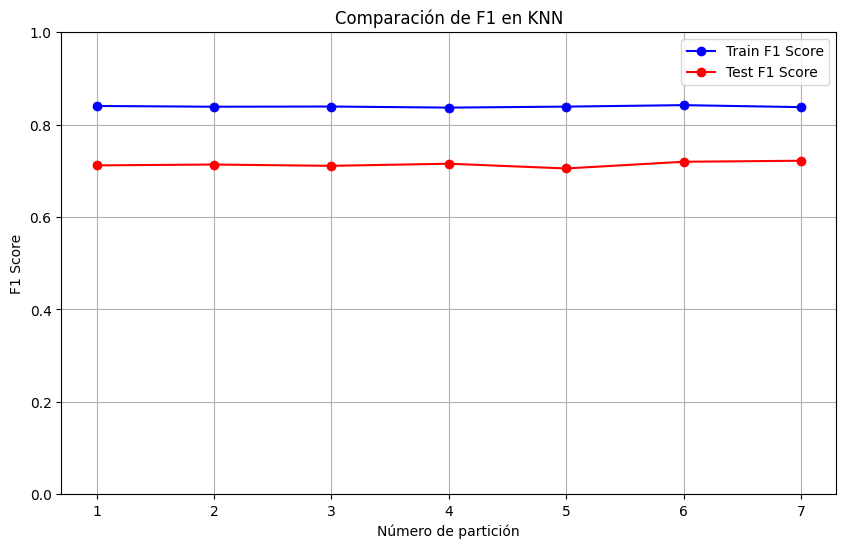

In [25]:
plot_results('KNN')

### Máquinas de soporte vectorial : SVC

Son sensibles a la escala de datos, por suerte, los datos han sido escalados en el preproceso

Existen varios kernel para el SVC: "
- linear: para usar un kernel lineal.
- poly: para usar un kernel polinomial.
- rbf: para usar un kernel de función de base radial.
- sigmoid: para usar un kernel sigmoidal.
- precomputed: para proporcionar una matriz de kernel precomputada."
<br><br>Como SVC no tiene partial_fit(), vamos a intentar usar SGDClassifier con loss="hinge" para simular un SVM lineal

In [26]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

model = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3)

scaler = StandardScaler()

for i in range (1, 8):
    
    df_part = globals()[f'df_train_{i}'] 
    X_part = df_part.drop(columns=['label'])  
    y_part = df_part['label']
    X_train_scaled = scaler.fit_transform(X_part) if i == 1 else scaler.transform(X_part)
    
    model.partial_fit(X_train_scaled, y_part, classes=np.unique(y_part))


In [27]:
dir = "../data/models"
model_path = os.path.join(dir, "SVM_linearSGD.joblib")
joblib.dump(model, model_path)


['../data/models\\SVM_linearSGD.joblib']

Hemos intentado hacer un PCA previo a la ejecución de SVC pero este modelo necesita toda la información así que hemos optado por probar entrenarlo solo con una partición

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import pandas as pd

X_combined = []
y_combined = []

scaler = StandardScaler()
pca = PCA(n_components=33)

for i in range(1, 8):
    df = globals()[f'df_train_{i}']
    
    X = df.drop('label', axis=1)  
    y = df['label']  
    
    X_train_scaled = scaler.fit_transform(X)  
    
    X_pca = pca.fit_transform(X_train_scaled) 
    
    X_combined.append(pd.DataFrame(X_pca)) 
    y_combined.append(y)

X_combined = pd.concat(X_combined, axis=0, ignore_index=True)
y_combined = pd.concat(y_combined, axis=0, ignore_index=True)

svc = SVC(kernel='linear', random_state=42, verbose=True)
svc.fit(X_combined, y_combined)


### Redes neuronales 

In [ ]:
from sklearn.neural_network import MLPClassifier

# Modelo de Red Neuronal
nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)

# Evaluamos y guardamos el resultado
results_dict['NeuralNetwork'] = evaluate_model(X_train, X_test, y_train, y_test, nn_model, 'NeuralNetwork')


## Comparación de resultados

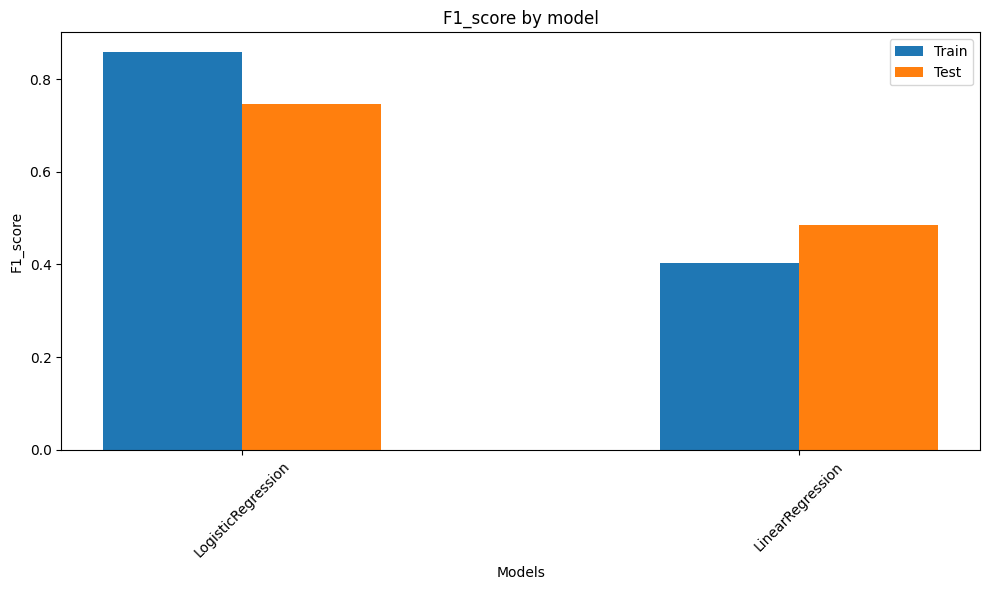

In [ ]:
plot_model_comparison(models_results, metric='f1_score')

## Ajuste de hiperparámetros

### OPTUNA con división a los modelos

In [24]:
import optuna
from sklearn.linear_model import SGDRegressor, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score

# dictionarios de hiperparametros para cada modelo
param_grids = {
    'SGDRegressor': {
        'alpha': lambda trial: trial.suggest_loguniform('alpha', 1e-4, 1e-1),
        'eta0': lambda trial: trial.suggest_loguniform('eta0', 1e-3, 1.0),
        'penalty': lambda trial: trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    },
    'SGDRegressorPolynomial': {
        'alpha': lambda trial: trial.suggest_loguniform('alpha', 1e-4, 1e-1),
        'eta0': lambda trial: trial.suggest_loguniform('eta0', 1e-3, 1.0),
        'penalty': lambda trial: trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
        'degree': lambda trial: trial.suggest_int('degree', 2, 5)  # Stopień wielomianu
    },
    'LogisticRegression': {
        'C': lambda trial: trial.suggest_loguniform('C', 0.01, 10),
        'penalty': lambda trial: trial.suggest_categorical('penalty', ['l2', 'l1']),
        'solver': lambda trial: trial.suggest_categorical('solver', ['liblinear', 'saga'])
    },
    'DecisionTreeClassifier': {
        'max_depth': lambda trial: trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': lambda trial: trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': lambda trial: trial.suggest_int('min_samples_leaf', 1, 10)
    },
    'KNeighborsClassifier': {
        'n_neighbors': lambda trial: trial.suggest_int('n_neighbors', 1, 20),
        'weights': lambda trial: trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': lambda trial: trial.suggest_categorical('metric', ['euclidean', 'manhattan'])
    },
    'SVC': {
        'C': lambda trial: trial.suggest_loguniform('C', 0.1, 10),
        'kernel': lambda trial: trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf']),
        'gamma': lambda trial: trial.suggest_loguniform('gamma', 1e-4, 1e-1)
    }
}


In [29]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def objective(trial, model_name='SGDRegressor'):
    # elige el modelo y los hiperparametros
    params = {param: fn(trial) for param, fn in param_grids[model_name].items()}
    
    if model_name == 'SGDRegressor':
        model = SGDRegressor(**params, random_state=42)
    elif model_name == 'SGDRegressorPolynomial':
        degree = params.pop('degree')  # Usuwamy 'degree' dla wielomianowego modelu
        model = Pipeline([
            ('poly', PolynomialFeatures(degree=degree)),  # Dodanie transformacji cech wielomianowych
            ('regressor', SGDRegressor(**params, random_state=42))
        ])    
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(**params, random_state=42)
    elif model_name == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(**params, random_state=42)
    elif model_name == 'KNeighborsClassifier':
        model = KNeighborsClassifier(**params)
    elif model_name == 'SVC':
        model = SVC(**params, random_state=42)
    else:
        raise ValueError("Unknown model")

    # Evaluar el modelo
    total_score = 0
    for i in range(1, 8):
        data_train = globals()[f'df_train_{i}']
        X_train = data_train.drop(columns=['label']).values
        y_train = data_train['label'].values
        
        if model_name in ['SGDRegressor', 'SGDRegressorPolynomial', 'LogisticRegression']:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_train)
            if model_name == 'SGDRegressor' or model_name == 'SGDRegressorPolynomial':
                score = mean_squared_error(y_train, y_pred)
            else:
                score = f1_score(y_train, y_pred, average='binary')
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_train)
            score = f1_score(y_train, y_pred, average='binary')
        
        total_score += score
        
    return total_score / 7  # Promedio de los resultados

#### Regresión Lineal

In [16]:
model_name = 'SGDRegressor'

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, model_name), n_trials=50)

print("Los mejores hiperparametros para el modelo", model_name, ":", study.best_params)

[I 2024-11-10 22:41:53,005] A new study created in memory with name: no-name-30267b8c-3529-4ea4-9146-d55fc4d3df04
C:\Users\48726\AppData\Local\Temp\ipykernel_9912\2595821963.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': lambda trial: trial.suggest_loguniform('alpha', 1e-4, 1e-1),
C:\Users\48726\AppData\Local\Temp\ipykernel_9912\2595821963.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta0': lambda trial: trial.suggest_loguniform('eta0', 1e-3, 1.0),
[I 2024-11-10 22:42:01,492] Trial 0 finished with value: 0.11880340509380409 and parameters: {'alpha': 0.0006862529899558914, 'eta0': 0.0647874316584021, 'penalty': 'elasticnet'}. Best is trial 0 with 

Los mejores hiperparametros para el modelo SGDRegressor : {'alpha': 0.00013117324584237315, 'eta0': 0.0010886262850832657, 'penalty': 'elasticnet'}


Los mejores hiperparametros para el modelo SGDRegressor : {'alpha': 0.00013117324584237315, 'eta0': 0.0010886262850832657, 'penalty': 'elasticnet'}

In [17]:
study = optuna.create_study(direction='minimize' if model_name == 'SGDRegressor' else 'maximize')
study.optimize(lambda trial: objective(trial, model_name), n_trials=50)

print("Los mejores hiperparametros para el modelo", model_name, ":", study.best_params)


[I 2024-11-10 22:53:57,209] A new study created in memory with name: no-name-5d59708f-b4cf-4391-9701-6f7658040585
C:\Users\48726\AppData\Local\Temp\ipykernel_9912\2595821963.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': lambda trial: trial.suggest_loguniform('alpha', 1e-4, 1e-1),
C:\Users\48726\AppData\Local\Temp\ipykernel_9912\2595821963.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta0': lambda trial: trial.suggest_loguniform('eta0', 1e-3, 1.0),
[I 2024-11-10 22:54:03,777] Trial 0 finished with value: 0.1148124502536516 and parameters: {'alpha': 0.01119894038517761, 'eta0': 0.005789315914226681, 'penalty': 'l1'}. Best is trial 0 with value: 0.

Los mejores hiperparametros para el modelo SGDRegressor : {'alpha': 0.00014127241522329069, 'eta0': 0.0010165838773616698, 'penalty': 'l2'}


Los mejores hiperparametros para el modelo SGDRegressor : {'alpha': 0.00014127241522329069, 'eta0': 0.0010165838773616698, 'penalty': 'l2'}

#### Regresión Polynomial

In [30]:
model_name = 'SGDRegressorPolynomial'

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, model_name), n_trials=50)

print("Los mejores hiperparametros para el modelo", model_name, ":", study.best_params)

[I 2024-11-10 23:13:40,470] A new study created in memory with name: no-name-6f91e731-85d5-471b-9b11-1623093ca045
C:\Users\48726\AppData\Local\Temp\ipykernel_9912\416101142.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': lambda trial: trial.suggest_loguniform('alpha', 1e-4, 1e-1),
C:\Users\48726\AppData\Local\Temp\ipykernel_9912\416101142.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta0': lambda trial: trial.suggest_loguniform('eta0', 1e-3, 1.0),
[W 2024-11-10 23:13:41,658] Trial 0 failed with parameters: {'alpha': 0.03802049362464376, 'eta0': 0.005151768106451124, 'penalty': 'l2', 'degree': 3} because of the following error: MemoryError((589300,

MemoryError: Unable to allocate 128. GiB for an array with shape (589300, 29260) and data type float64

#### Regresión Logistica

In [ ]:
model_name = 'LogisticRegression'

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, model_name), n_trials=50)

print("Los mejores hiperparametros para el modelo", model_name, ":", study.best_params)

[I 2024-11-10 23:30:20,834] A new study created in memory with name: no-name-18443fc9-baeb-420c-821a-ae2022c6b2a4
C:\Users\48726\AppData\Local\Temp\ipykernel_9912\416101142.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': lambda trial: trial.suggest_loguniform('C', 0.01, 10),
c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_it

Como la ejecutación de este codigo dura demaciado (despues de casi 700 minutos solo se han realizado 10 de 50 pruebas), lo pauso. OPTUNA nos da infroamción: 

"Trial 10 finished with value: 0.8613615164343115 and parameters: **{'C': 9.144501588851943, 'penalty': 'l2', 'solver': 'saga'}**. *Best is trial 10 with value: 0.8613615164343115.*"

Y como no tenemos mas tiempo, vamos a usar los hiperparametros de trial 10.

#### Decission Trees

In [ ]:
model_name = 'DecisionTreeClassifier'

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, model_name), n_trials=50)

print("Los mejores hiperparametros para el modelo", model_name, ":", study.best_params)

#### KNN

In [ ]:
model_name = 'KNeighborsClassifier'

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, model_name), n_trials=50)

print("Los mejores hiperparametros para el modelo", model_name, ":", study.best_params)

#### SVC

In [ ]:
model_name = 'SVC'

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, model_name), n_trials=50)

print("Los mejores hiperparametros para el modelo", model_name, ":", study.best_params)

#### Redes Neuronales

In [ ]:
model_name = ''

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, model_name), n_trials=50)

print("Los mejores hiperparametros para el modelo", model_name, ":", study.best_params)

## Nuevos resultados

### Regresión Lineal DONE

##### Entrenamiento

Como LinealRegression no permite hacer partial fit, usamos SGDRegressor con loss = squared error y así realiza lo mismo que el original, minimizar el error cuadrático

In [19]:
model = SGDRegressor(loss='squared_error', random_state=42, alpha=0.00013117324584237315, eta0=0.0010886262850832657, penalty='elasticnet')

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values
    
    model.partial_fit(X_train, y_train)


In [20]:
dir = "../data/models"
model_path = os.path.join(dir, "new_LinearRegression.joblib")
joblib.dump(model, model_path)

['../data/models\\new_LinearRegression.joblib']

##### Predicción

In [21]:
# Cargar modelo de LinearRegression
model = joblib.load("../data/models/new_LinearRegression.joblib")

In [22]:
prediction(model, 'LinearRegression')

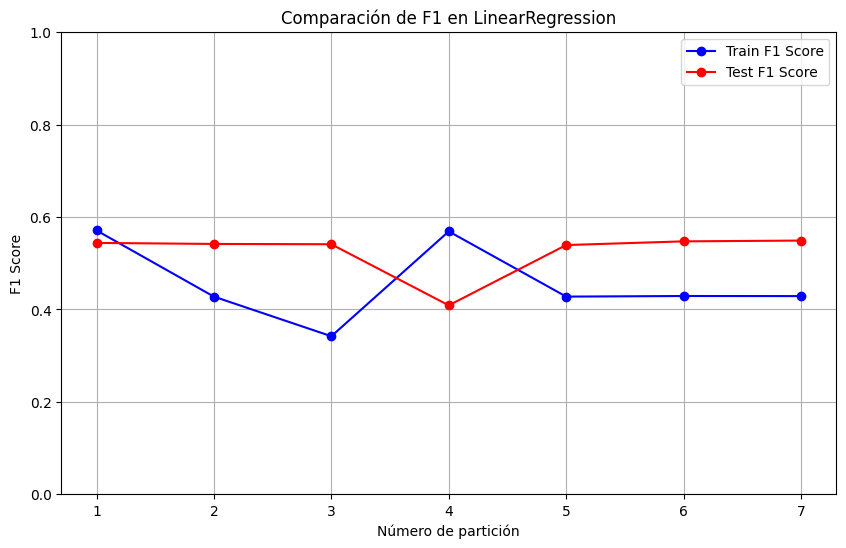

In [23]:
plot_results('LinearRegression')

### Regresión Polinomial

Tenemos un problema ya que la matriz generada por aumentar el grado de los datos es demasiado grande aunque sea simplemente de grado 2.

Debido al tamaño del dataframe no podemos utilizar SVC así que intentaré aplicar un PCA y ver con cuántas columnas me quedo

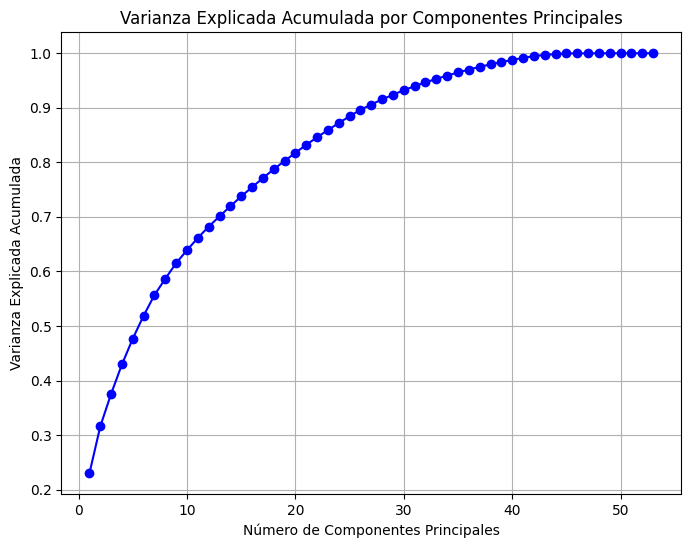

El número óptimo de componentes es 33


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler

pca = IncrementalPCA(n_components=53) 
scaler = StandardScaler()

explained_variance_ratio = []  

for i in range(1, 8):
    df_part = globals()[f'df_train_{i}']
    X_part = df_part.drop(columns=['label'])  
    X_train_scaled = scaler.fit_transform(X_part) if i == 1 else scaler.transform(X_part)  # Escalar
    
    pca.partial_fit(X_train_scaled)
    
    explained_variance_ratio.append(pca.explained_variance_ratio_)

total_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(total_explained_variance) + 1), total_explained_variance, marker='o', color='b')
plt.title('Varianza Explicada Acumulada por Componentes Principales')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.grid(True)
plt.show()

# Puedes elegir cuántos componentes usar basado en la varianza explicada acumulada
# Por ejemplo, si deseas que se explique al menos el 95% de la varianza
n_components_opt = np.argmax(total_explained_variance >= 0.95) + 1  # Primer componente que llega al 95%
print(f"El número óptimo de componentes es {n_components_opt}")


In [ ]:
# Generar un dataframes pca
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
n_components = 33  

pca = PCA(n_components=n_components)

for i in range(1,8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values    

    data_test = globals()[f'df_test_{i}']
    X_test = data_test.drop(columns=['label']).values
    y_test = data_test['label'].values

    
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)


    # Lo guardo en un DataFrame para usarlo luego
    data_train_pca = pd.DataFrame(data=X_train_pca, columns=[f'PC{i}' for i in range(1, n_components+1)])
    data_train_pca['label'] = y_train
    globals()[f'df_train_{i}_pca'] = data_train_pca

    data_test_pca = pd.DataFrame(data=X_test_pca, columns=[f'PC{i}' for i in range(1, n_components+1)])
    data_test_pca['label'] = y_test
    globals()[f'df_test_{i}_pca'] = data_test_pca

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

degree = 2   # ESTE DATO TENEMOS QUE AJUSTARLO (define el grado del polinomio)

model = SGDRegressor(max_iter=1, tol=None, warm_start=True)

poly = PolynomialFeatures(degree)
scaler = StandardScaler()

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}_pca']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values

    X_train_poly = poly.fit_transform(X_train)  
    if i == 1:
        X_train_scaled = scaler.fit_transform(X_train_poly)  
    else:
        X_train_scaled = scaler.transform(X_train_poly) 
        
    model.partial_fit(X_train_scaled, y_train)


In [ ]:
dir = "../data/models"
model_path = os.path.join(dir, "PolinomialRegression.joblib")
joblib.dump(model, model_path)

['../data/models\\PolinomialRegression.joblib']

##### Predicción

In [ ]:
# Cargar modelo de LogisticRegression
model = joblib.load("../data/models/PolinomialRegression.joblib")

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures, StandardScaler


# poly = PolynomialFeatures(degree)
# scaler = StandardScaler()


# for i in range(1, 8):
#     data_train = globals()[f'df_train_{i}_pca']
#     X_train = data_train.drop(columns=['label']).values
#     y_train = data_train['label'].values

#     data_test = globals()[f'df_test_{i}_pca']
#     X_test = data_test.drop(columns=['label']).values
#     y_test = data_test['label'].values

#     X_test_poly = poly.fit_transform(X_test)
#     X_train_poly = poly.fit_transform(X_train)  
#     if i == 1:
#         X_train_scaled = scaler.fit_transform(X_train_poly)  
#         X_test_scaled = scaler.fit_transform(X_test_poly)
#     else:
#         X_train_scaled = scaler.transform(X_train_poly) 
#         X_test_scaled = scaler.transform(X_test_poly)

#     data_train_poly = pd.DataFrame(data=X_train_scaled)
#     data_train_poly['label'] = y_train
#     globals()[f'df_train_{i}_pca_poly'] = data_train_poly

#     data_test_poly = pd.DataFrame(data=X_test_scaled)
#     data_test_poly['label'] = y_test
#     globals()[f'df_test_{i}_pca_poly'] = data_test_poly


In [ ]:
prediction(model, 'PolinomialRegression')

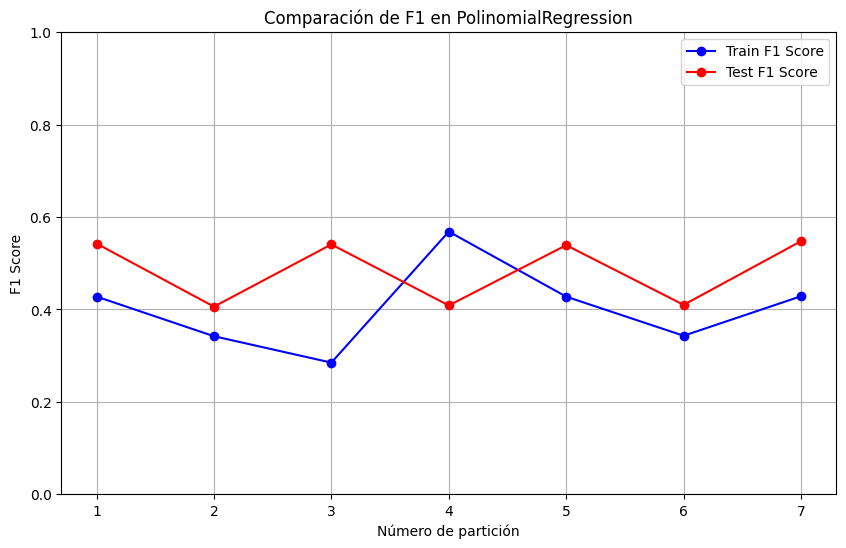

In [ ]:
plot_results('PolinomialRegression')

### Regresión Logística: DONE

##### Entrenamiento

Como LinearRegression no permite un entrenamiento por partes, usamos SGDClasifier en su lugar con "loss='log'" para realizar una clasificación utilizando el algoritmo de gradiente descendente estocástico.

In [ ]:
model = SGDClassifier(loss='log_loss', random_state=42)

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values

    model.partial_fit(X_train, y_train, classes=np.unique(y_train))


In [ ]:
dir = "../data/models"
model_path = os.path.join(dir, "LogisticRegression.joblib")
joblib.dump(model, model_path)


['../data/models\\LogisticRegression.joblib']

##### Predicción

In [ ]:
# Cargar modelo de LogisticRegression
model = joblib.load("../data/models/LogisticRegression.joblib")

In [ ]:
prediction(model, 'LogisticRegression')

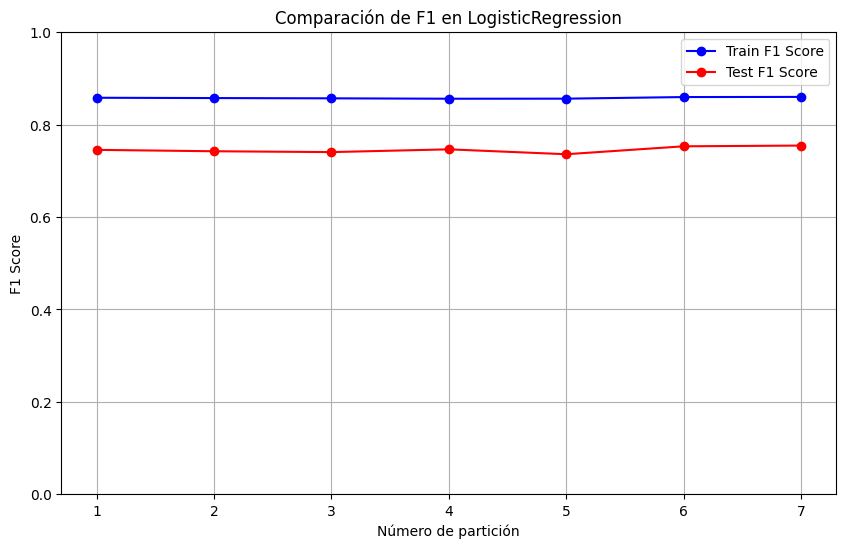

In [ ]:
plot_results('LogisticRegression')

### Árboles de decisión

Se recomienda hacer un PCA cuando tenemos alta dimensionalidad

In [ ]:
for i in range(1,8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values    

    data_test = globals()[f'df_test_{i}']
    X_test = data_test.drop(columns=['label']).values
    y_test = data_test['label'].values

    # Aplicar PCA para reducir la dimensionalidad
    n_components = 2  # DATO AJUSTABLE
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Lo guardo en un DataFrame para usarlo luego
    data_train_pca = pd.DataFrame(data=X_train_pca, columns=[f'PC{i}' for i in range(1, n_components+1)])
    data_train_pca['label'] = y_train
    globals()[f'df_train_{i}_pca'] = data_train_pca

    data_test_pca = pd.DataFrame(data=X_test_pca, columns=[f'PC{i}' for i in range(1, n_components+1)])
    data_test_pca['label'] = y_test
    globals()[f'df_test_{i}_pca'] = data_test_pca

##### Entrenamiento

Los árboles de decisión no soportan partial_fit() así que optamos por generar un árbol para cada partición y luego aplicar un ensemble

<i>"Para la clasificación con pocas clases, min_samples_leaf=1 suele ser la mejor opción.
"</i>
<br> <br><i>"Podemos empezar con min_muestras_hoja=5 como valor inicial. Si el tamaño de la muestra varía mucho, se puede utilizar un número flotante como
porcentaje en estos dos parámetros."</i>

VotingClassifier -> hace una "votación por mayoría" de los árboles por separado para obtener la predicción final. "soft" indica que utiliza el promedio de probabilidades en lugar de la mayoría de votos

In [ ]:
models = []

for i in range(1, 8):
    data_frame = globals()[f'df_train_{i}']
    X_batch = data_frame.drop(columns=['label']).values
    y_batch = data_frame['label'].values

    # Entrenar un modelo individual para cada partición !!!!!!
    model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1)
    model.fit(X_batch, y_batch)
    models.append((f'model_{i}', model))

# Hacer el ensemble
ensemble_model = VotingClassifier(estimators=models, voting='soft')


No sé para qué hago esto si me obliga luego a entrenarlo con todos los datos duh

In [ ]:

X_train_full = np.vstack([globals()[f'df_train_{i}'].drop(columns=['label']).values for i in range(1, 8)])
y_train_full = np.hstack([globals()[f'df_train_{i}']['label'].values for i in range(1, 8)])

# Ajustar el ensemble con los datos completos
ensemble_model.fit(X_train_full, y_train_full)

VotingClassifier(estimators=[('model_1', DecisionTreeClassifier(max_depth=3)),
                             ('model_2', DecisionTreeClassifier(max_depth=3)),
                             ('model_3', DecisionTreeClassifier(max_depth=3)),
                             ('model_4', DecisionTreeClassifier(max_depth=3)),
                             ('model_5', DecisionTreeClassifier(max_depth=3)),
                             ('model_6', DecisionTreeClassifier(max_depth=3)),
                             ('model_7', DecisionTreeClassifier(max_depth=3))],
                 voting='soft')

In [ ]:
dir = "../data/models"
model_path = os.path.join(dir, "DecisionTree.joblib")
joblib.dump(ensemble_model, model_path)

['../data/models\\DecisionTree.joblib']

##### Predicción

In [ ]:
# Cargar modelo de LogisticRegression
model = joblib.load("../data/models/DecisionTree.joblib")

In [ ]:
prediction(model, 'DecisionTree')

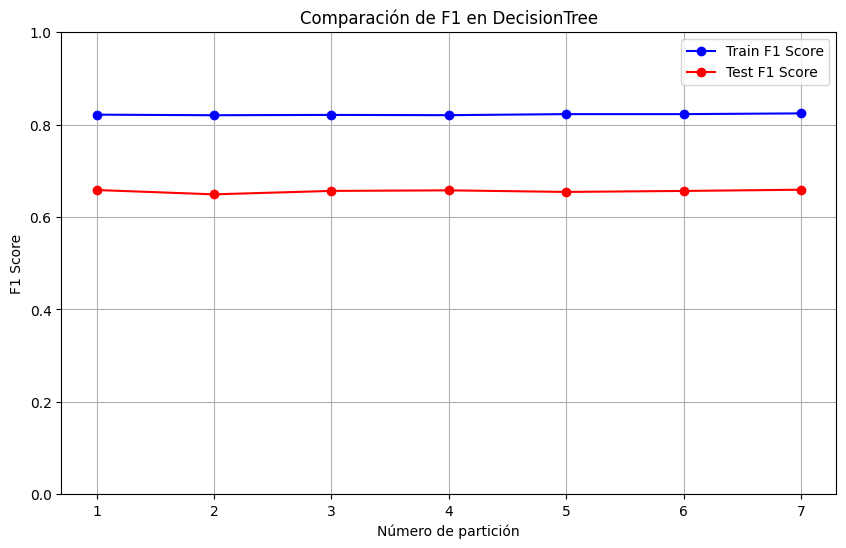

In [ ]:
plot_results('DecisionTree')

### Basado en instancias : KNN -> DONE? (solo con una partición pequeña)

##### Entrenamiento

He intentado con annoy (según la documentación, permite aproximar KNN con un enfoque eficiente en memoria) pero el kernel muere intentando entrenarlo

Como no sirve nada, voy a coger una muestra pequeña representativa y voy a entrenar el modelo con ella

In [ ]:
import pandas as pd

# Definir el tamaño de la muestra (1% en este ejemplo)
sample_fraction = 0.01  # Ajusta esto según tus necesidades

# DataFrames particionados de tus datos, aquí simulados como lista
partitions = [globals()[f'df_train_{i}'] for i in range(1, 8)]

# Crear lista para almacenar las muestras
sampled_data = []

# Iterar sobre cada partición y tomar una muestra estratificada
for df in partitions:
    sampled_df = df.groupby('label', as_index=False).apply(
        lambda x: x.sample(frac=sample_fraction, random_state=42)
    ).reset_index(drop=True)  # Eliminar índice adicional
    sampled_data.append(sampled_df)

# Concatenar todas las muestras para tener un único DataFrame de muestra
final_sample = pd.concat(sampled_data, ignore_index=True)

# Confirmación de la muestra final y de que 'label' está presente
print("Tamaño de la muestra final:", final_sample.shape)


C:\Users\eleni\AppData\Local\Temp\ipykernel_3320\2424558243.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label', as_index=False).apply(
C:\Users\eleni\AppData\Local\Temp\ipykernel_3320\2424558243.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label', as_index=False).apply(
C:\Users\eleni\AppData\Local\Temp\ipykernel_3320\2424558243.py:14: Depre

Tamaño de la muestra final: (39182, 55)


C:\Users\eleni\AppData\Local\Temp\ipykernel_3320\2424558243.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label', as_index=False).apply(
C:\Users\eleni\AppData\Local\Temp\ipykernel_3320\2424558243.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label', as_index=False).apply(


In [ ]:
print(final_sample.columns)


Index(['ID', 'Payment_6804', 'Infraction_CGP', 'Base_7744', 'Base_80863',
       'Risk_1930', 'Infraction_SNZ', 'Base_02683', 'Infraction_QJJF',
       'Base_76065', 'Risk_0322', 'Infraction_GGO', 'Base_39598', 'Base_6187',
       'Base_85131', 'Risk_9995', 'Infraction_AYWV', 'Base_36384',
       'Base_24406', 'Infraction_BSU', 'Infraction_ZYW', 'Base_1039',
       'Base_0580', 'Expenditure_RGD', 'Base_69608', 'Base_6852', 'Base_22178',
       'Infraction_ZTYG', 'Expenditure_UWVG', 'Base_3041', 'Payment_3207',
       'Infraction_QKZN', 'Infraction_CZE', 'Base_66195', 'Risk_4553',
       'Base_67585', 'Infraction_HFSI', 'Infraction_ETH', 'Base_2810',
       'Risk_8902', 'Infraction_BGGU', 'Infraction_NMCB', 'Infraction_XEPQ',
       'Infraction_ZMKI', 'Infraction_RKTA', 'Infraction_SIA',
       'Infraction_QEY', 'Infraction_VHHP', 'Infraction_LIES',
       'Infraction_QWWW', 'Infraction_YQXM', 'Infraction_QGR',
       'Infraction_LSX', 'Expenditure_AHF_year', 'label'],
      dtype='obje

In [ ]:
# Entrenar un modelo de KNN con final_sample
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
X = final_sample.drop(columns=['label']).values
y = final_sample['label'].values
model.fit(X, y)

KNeighborsClassifier()

In [ ]:
dir = "../data/models"
model_path = os.path.join(dir, "KNN.joblib")
joblib.dump(model, model_path)


['../data/models\\KNN.joblib']

##### Predicción

In [ ]:
model = joblib.load("../data/models/KNN.joblib")

In [ ]:
prediction(model, 'KNN')

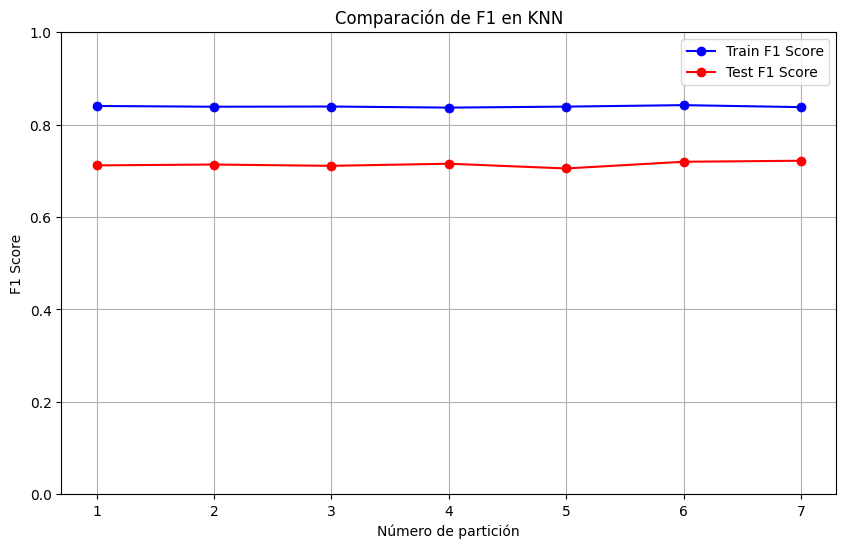

In [ ]:
plot_results('KNN')

### next

### next